In [37]:
import numpy as np
from sedpy.observate import load_filters
from prospect.io import read_results as pread
import matplotlib.pyplot as plt
import tqdm
import glob
import pandas as pd

import matplotlib
matplotlib.rcParams.update({
    "savefig.facecolor": "w",
    "figure.facecolor" : 'w',
    "figure.figsize" : (10,8),
    "text.color": "k",
    "legend.fontsize" : 20,
    "font.size" : 30,
    "axes.edgecolor": "k",
    "axes.labelcolor": "k",
    "axes.linewidth": 3,
    "xtick.color": "k",
    "ytick.color": "k",
    "xtick.labelsize" : 25,
    "ytick.labelsize" : 25,
    "ytick.major.size" : 12,
    "xtick.major.size" : 12,
    "ytick.major.width" : 2,
    "xtick.major.width" : 2,
    "font.family": "Times",
    "mathtext.fontset" : "cm"
})

savedir = '/Users/sidneylower/Documents/atten_demos/'

In [2]:
def build_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps


def build_noise(**extras):
    return None, None

In [275]:
galex = ['galex_FUV', 'galex_NUV']
hst_wfc3_uv  = ['wfc3_uvis_f275w', 'wfc3_uvis_f336w', 'wfc3_uvis_f475w','wfc3_uvis_f555w', 'wfc3_uvis_f606w', 'wfc3_uvis_f814w']
sdss = ['sdss_i0']
hst_wfc3_ir = ['wfc3_ir_f105w', 'wfc3_ir_f125w', 'wfc3_ir_f140w', 'wfc3_ir_f160w']
spitzer_irac = ['spitzer_irac_ch1']
spitzer_mips = ['spitzer_mips_24']
herschel_pacs = ['herschel_pacs_70', 'herschel_pacs_100', 'herschel_pacs_160']
herschel_spire = ['herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500']
jwst_miri = ['jwst_f560w', 'jwst_f770w', 'jwst_f1000w', 'jwst_f1130w', 'jwst_f1280w', 'jwst_f1500w', 'jwst_f1800w']
jwst_nircam = ['jwst_f070w', 'jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 'jwst_f277w']
filternames = (galex + hst_wfc3_uv +  hst_wfc3_ir + jwst_miri + jwst_nircam + 
               spitzer_irac + spitzer_mips + herschel_pacs + herschel_spire)

In [14]:
def get_best(res, **kwargs):
    imax = np.argmax(res['lnprobability'])
    theta_best = res['chain'][imax, :].copy()

    return theta_best
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

In [38]:
res, _, _ = pread.results_from('/Users/sidneylower/Documents/atten_demos/sfh4_dust4_Mod_matches_Obs.h5')
reskc, _, modkc = pread.results_from('/Users/sidneylower/Documents/atten_demos/sfh4_dust4_Mod_fixed_no_dust.h5')
rescal, _, modcal = pread.results_from('/Users/sidneylower/Documents/atten_demos/sfh4_dust4_Mod_Cal.h5')

In [10]:
modog = build_model()

In [12]:
sps = build_sps()

In [17]:
thetas_og = get_best(res)
thetas_cal = get_best(rescal)
thetas_kc= get_best(reskc)

In [18]:
spec_og, _, _ = modog.mean_model(thetas_og, res['obs'], sps)
spec_cal, _, _ = modcal.mean_model(thetas_cal, rescal['obs'], sps)
spec_kc, _, _ = modkc.mean_model(thetas_kc, reskc['obs'], sps)


In [35]:
nodust_thetas = [3.5e11, -0.2, 0.0, 10.0, 1.0, 0.0, 0.0, -0.7, 0.0, 0.0]

In [36]:
spec_no_dust, _ , _ = modog.mean_model(nodust_thetas, rescal['obs'], sps)

In [24]:
spec_real, phot_real, _ = modog.mean_model(res['obs']['true_thetas'], rescal['obs'], sps)

In [25]:
spec_waves = sps.wavelengths
filter_waves = [x.wave_mean for x in res['obs']['filters']]
savedir = '/Users/sidneylower/Documents/atten_demos/'

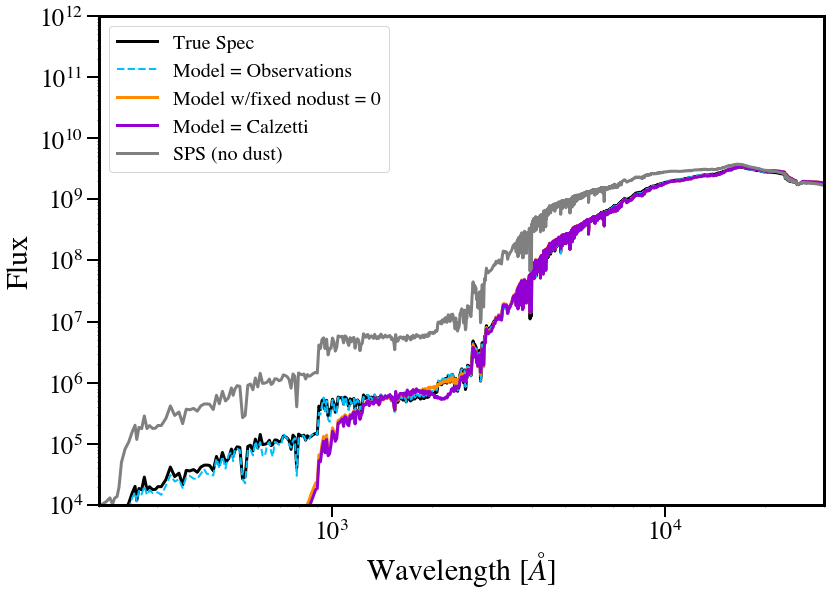

In [38]:
plt.figure(figsize=(13, 9))
plt.loglog(spec_waves, spec_real, color='black', lw=3, label='True Spec')
plt.loglog(spec_waves, spec_og, color='deepskyblue', ls='--', lw=2, label='Model = Observations')
plt.loglog(spec_waves, spec_cal, color='darkorange', lw=3, label='Model w/fixed nodust = 0')
plt.loglog(spec_waves, spec_kc, color='darkviolet', lw=3, label='Model = Calzetti')
plt.loglog(spec_waves, spec_no_dust, color='grey', lw=3, label='SPS (no dust)')
#plt.errorbar(filter_waves, phot_real, yerr=[x*0.03 for x in phot_real], color='black', ls='None',marker='o')
plt.ylim([1e4, 1e12])
plt.xlim([2e2, 3e4])
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\AA$]')
plt.legend(loc='upper left')
plt.savefig(savedir+'sed.png', dpi=300, bbox_inches='tight')

In [303]:
thetas = model.theta_labels()

In [427]:
mass_og = [np.log10(item[thetas.index('mass')]) for item in res['chain']]
mass_kcfixed = [np.log10(item[thetas.index('mass')]) for item in reskc['chain']]
mass_cal = [np.log10(item[thetas.index('mass')]) for item in resCal['chain']]

Text(10.2, 1.0, '$\\sigma$ = 0.66')

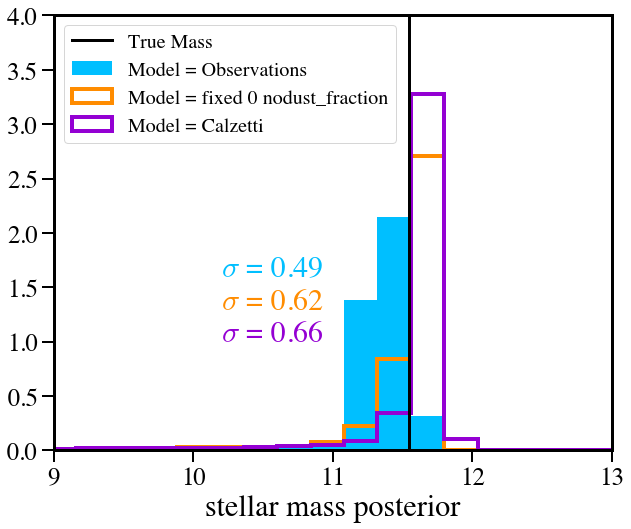

In [428]:
plt.hist(mass_og, range=(7, 13), bins=25, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(mass_kcfixed, range=(7, 13), bins=25, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_fraction')
plt.hist(mass_cal, range=(7, 13), bins=25, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')
plt.plot([np.log10(reskc['obs']['true_thetas'][thetas.index('mass')]),np.log10(reskc['obs']['true_thetas'][thetas.index('mass')])], [0, 7], color='black', lw=3, label='True Mass')
plt.xlim([9, 13])
plt.ylim([0, 4])
plt.xlabel('stellar mass posterior')
plt.legend(loc='upper left', fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(mass_og)), xy=(10.2, 1.6),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(mass_kcfixed)), xy=(10.2, 1.3),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(mass_cal)), xy=(10.2, 1.),color='darkviolet')
#plt.savefig(savedir+'masses.png', dpi=300, bbox_inches='tight')

In [429]:
metal_og = [item[thetas.index('logzsol')] for item in res['chain']]
metal_kcfixed = [item[thetas.index('logzsol')] for item in reskc['chain']]
metal_cal = [item[thetas.index('logzsol')] for item in resCal['chain']]

Text(0.5, 0, 'Log(Z / Z$_{\\odot}$) posterior')

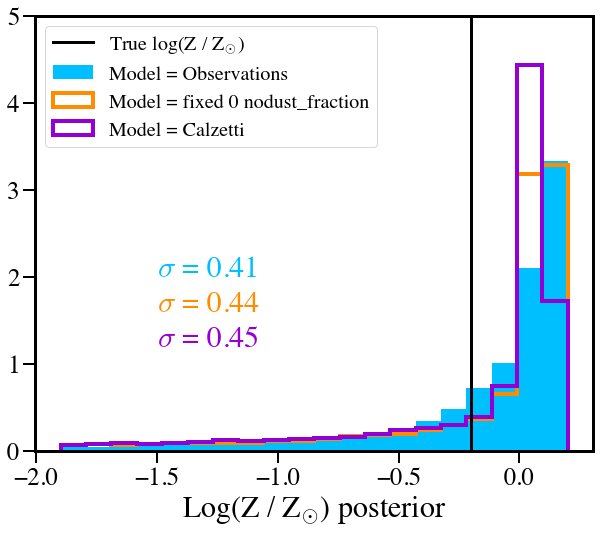

In [430]:
plt.hist(metal_og, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(metal_kcfixed, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_fraction')
plt.hist(metal_cal, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')

plt.ylim([0, 5])
plt.plot([reskc['obs']['true_thetas'][thetas.index('logzsol')],reskc['obs']['true_thetas'][thetas.index('logzsol')]], [0, 7], color='black', lw=3, label='True log(Z / Z$_{\odot}$)')

plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(metal_og)), xy=(-1.5, 2),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(metal_kcfixed)), xy=(-1.5, 1.6),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(metal_cal)), xy=(-1.5, 1.2),color='darkviolet')
plt.xlabel('Log(Z / Z$_{\odot}$) posterior')
#plt.savefig(savedir+'Z.png', dpi=300, bbox_inches='tight')

In [363]:
tage_og = [3+item[thetas.index('tage')] for item in res['chain']]
tage_kcfixed = [item[thetas.index('tage')] for item in reskc['chain']]
tage_cal = [item[thetas.index('tage')] for item in resCal['chain']]

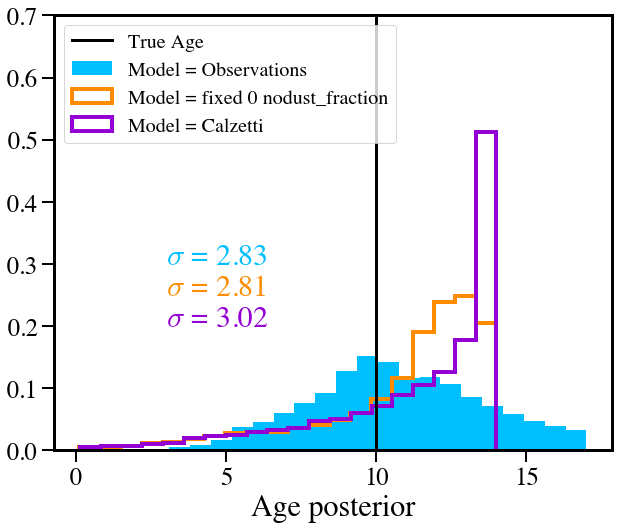

In [373]:
plt.hist(tage_og, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(tage_kcfixed, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_fraction')
plt.hist(tage_cal, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')

plt.ylim([0, 0.7])
plt.plot([reskc['obs']['true_thetas'][thetas.index('tage')], reskc['obs']['true_thetas'][thetas.index('tage')]], [0, 7], color='black', lw=3, label='True Age')

plt.legend(loc='upper left', fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tage_og)), xy=(3, 0.3),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tage_kcfixed)), xy=(3, 0.25),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tage_cal)), xy=(3, 0.2),color='darkviolet')
plt.xlabel('Age posterior')
plt.savefig(savedir+'age.png', dpi=300, bbox_inches='tight')

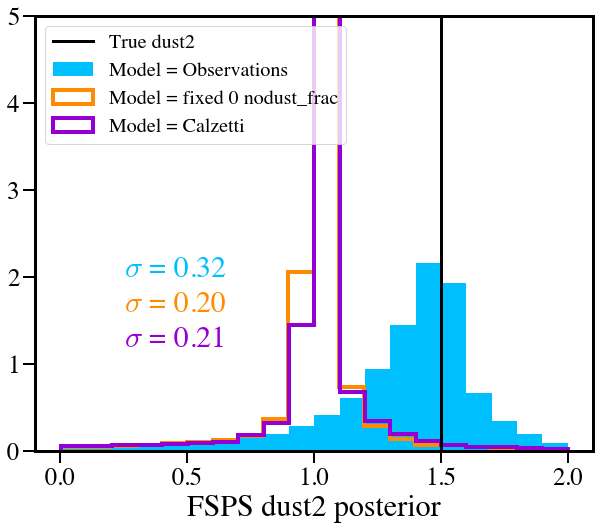

In [366]:
dust_og = [item[thetas.index('dust2')] for item in res['chain']]
dust_kcfixed = [item[thetas.index('dust2')] for item in reskc['chain']]
dust_cal = [item[thetas.index('dust2')] for item in resCal['chain']]
plt.hist(dust_og, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(dust_kcfixed, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_frac')
plt.hist(dust_cal, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')

plt.ylim([0, 5])
plt.plot([reskc['obs']['true_thetas'][thetas.index('dust2')], reskc['obs']['true_thetas'][thetas.index('dust2')]], [0, 7], color='black', lw=3, label='True dust2')

plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_og)), xy=(0.25, 2),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_kcfixed)), xy=(0.25, 1.6),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_cal)), xy=(0.25, 1.2),color='darkviolet')
plt.xlabel('FSPS dust2 posterior')
plt.savefig(savedir+'Av.png', dpi=300, bbox_inches='tight')

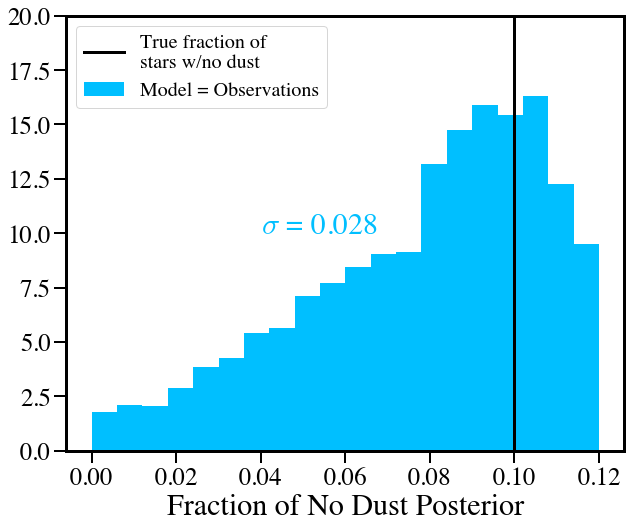

In [371]:
nodust_post = [item[thetas.index('frac_nodust')] for item in res['chain']]
plt.hist(nodust_post, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.plot([0.1, 0.1], [0, 20], color='black', lw=3, label='True fraction of\nstars w/no dust')
plt.ylim([0, 20])
plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.3f}".format(np.std(nodust_post)), xy=(0.04, 10),color='deepskyblue')
#plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_cal)), xy=(0.5, 1.6),color='darkorange')
plt.xlabel('Fraction of No Dust Posterior')
plt.savefig(savedir+'frac_nodust.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'UV Bump Strength Posterior')

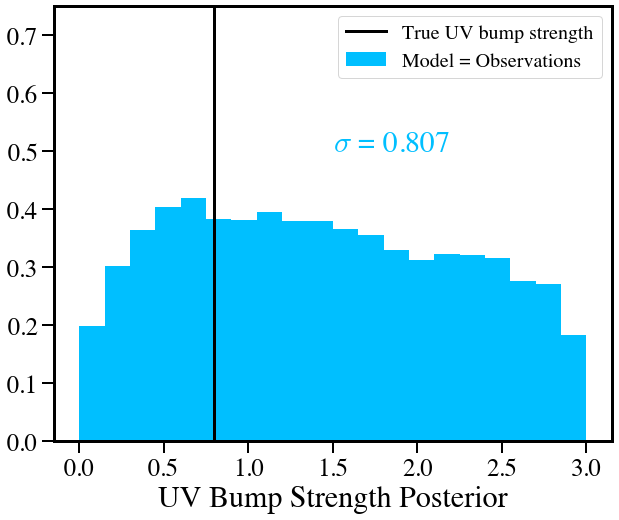

In [369]:
uvb_post = [item[thetas.index('uvb')] for item in res['chain']]
plt.hist(uvb_post, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.plot([0.8, 0.8], [0, 20], color='black', lw=3, label='True UV bump strength')
plt.ylim([0, 0.75])
plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.3f}".format(np.std(uvb_post)), xy=(1.5, 0.5),color='deepskyblue')
plt.xlabel('UV Bump Strength Posterior')

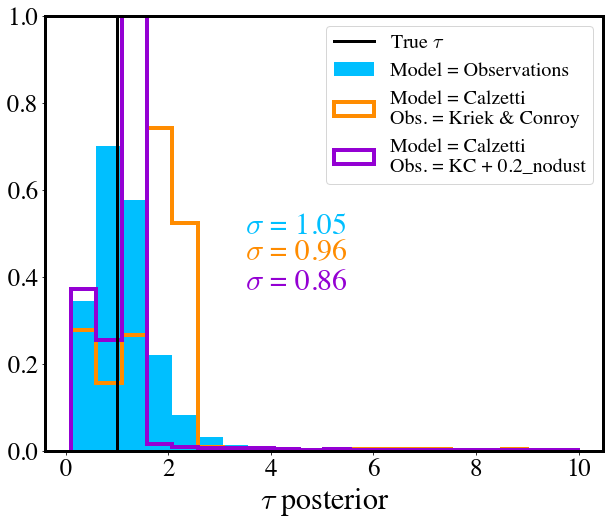

In [199]:
tau_post = [item[thetas.index('tau')] for item in res['chain']]
tau_post2 = [item[thetas.index('tau')] for item in res2['chain']]
tau_cal = [item[thetas.index('tau')] for item in resCal['chain']]
plt.hist(tau_post, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(tau_cal, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = Calzetti\nObs. = Kriek & Conroy')
plt.hist(tau_post2, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti\nObs. = KC + 0.2_nodust')

plt.ylim([0, 1])
plt.plot([1, 1], [0, 7], color='black', lw=3, label=r'True $\tau$')

plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tau_post)), xy=(3.5, 0.5),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tau_cal)), xy=(3.5, 0.44),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tau_post2)), xy=(3.5, 0.37),color='darkviolet')
plt.xlabel(r'$\tau$ posterior')
plt.savefig(savedir+'tau.png', dpi=300, bbox_inches='tight')

In [1]:
def get_best(res, **kwargs):
    imax = np.argmax(res['lnprobability'])
    theta_best = res['chain'][imax, :].copy()

    return theta_best
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

#global attn curve params
dd63=6300.00
lamv=3000.0
dlam=350.0
lamuvb=2175.0

In [2]:
def Kriek_Conroy_modified(lam, dust2, dust_index, uvb): 
    
    w63 = find_nearest(lam,dd63)
    cal00 = np.zeros(np.shape(lam)[0])
    for i in range(w63, np.shape(lam)[0]):
        cal00[i] = 1.17*( -1.857+1.04*(1.0e4/lam[i])) + 1.78 
    for i in range(0, w63):
        cal00[i]= 1.17*(-2.156+1.509*(1.0e4/lam[i]) -0.198*(1.0e4/lam[i])**2 + 0.011*(1.0e4/lam[i])**3) + 1.78
    #R=4.05 NB: I'm not sure I have this normalization correct...                                                                                            
    cal00 = (cal00/0.44/4.05)

    eb = uvb                                                                                                          

    #Drude profile for 2175A bump                                                                                                                            
    drude = eb*(lam*dlam)**2 / ( (lam**2-lamuvb**2)**2 + (lam*dlam)**2 )

    attn_curve = dust2*(cal00+drude/4.05)*(lam/lamv)**dust_index

    return attn_curve

In [3]:
def Calzetti(lam, dust2):
    w63 = find_nearest(lam,dd63)
    cal00 = np.zeros(np.shape(lam)[0])
    for i in range(w63, np.shape(lam)[0]):
        cal00[i] = 1.17*( -1.857+1.04*(1.0e4/lam[i])) + 1.78
    for i in range(0, w63):
        cal00[i]= 1.17*(-2.156+1.509*(1.0e4/lam[i]) -0.198*(1.0e4/lam[i])**2 + 0.011*(1.0e4/lam[i])**3) + 1.78
    #R=4.05 NB: I'm not sure I have this normalization correct...                                                                                            
    cal00 = cal00/0.44/4.05
    
    attn_curve = cal00 * dust2
    
    return attn_curve

In [490]:
og_thetas = get_best(res)
fixed_thetas = get_best(reskc)
cal_thetas = get_best(resCal)
true_thetas = reskc['obs']['true_thetas']

In [453]:
len(fixed_thetas)

9

In [455]:
thetas

['mass',
 'logzsol',
 'dust2',
 'tage',
 'tau',
 'duste_umin',
 'duste_gamma',
 'dust_index',
 'frac_nodust',
 'uvb']

In [454]:
len(og_thetas)

10

In [461]:
true_thetas

array([ 3.5e+11, -2.0e-01,  1.5e+00,  1.0e+01,  1.0e+00,  1.0e+00,
        1.0e+00, -7.0e-01,  8.0e-01])

In [53]:
wav = np.linspace(200, 1e5, 1000)

In [54]:
true_curve = Noll09(wav, 1.5, -0.7, 3.0)

In [481]:
true_thetas

array([ 3.5e+11, -2.0e-01,  1.5e+00,  1.0e+01,  1.0e+00,  1.0e+00,
        1.0e+00, -7.0e-01,  8.0e-01])

In [487]:
thetas

['mass',
 'logzsol',
 'dust2',
 'tage',
 'tau',
 'duste_umin',
 'duste_gamma',
 'dust_index',
 'frac_nodust',
 'uvb']

In [488]:
og_thetas

array([ 3.30447844e+11, -1.82817621e-01,  1.48429362e+00,  6.51129635e+00,
        9.35519097e-01,  9.83222679e-01,  1.09738609e-03, -1.21978710e-02,
        9.60365444e-02,  1.29187379e+00])

In [52]:
og_curve = Noll09(wav, og_thetas[2], og_thetas[7], 3)

NameError: name 'wav' is not defined

In [492]:
fixed_curve = Noll09(wav, fixed_thetas[2], fixed_thetas[7], fixed_thetas[-1])

In [493]:
cal_curve = Calzetti(wav, cal_thetas[2])

Text(0.5, 0, 'Wavelength [$\\AA$]')

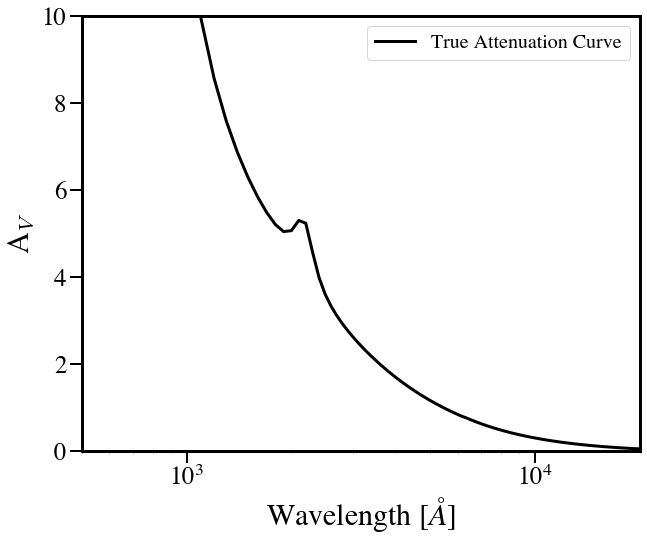

In [55]:
plt.plot(wav, true_curve, color='black', lw=3, label='True Attenuation Curve')
#plt.plot(wav, og_curve, color='deepskyblue', lw=3, label='Model = Observations')

#plt.plot(wav, fixed_curve, color='darkorange', lw=3, label='Model w/fixed nodust=0')
#plt.plot(wav, cal_curve, color='darkviolet', lw=3, label='Model = Calzetti')
plt.xscale('log')
plt.ylim([0, 10])
plt.xlim([5e2, 2e4])
plt.legend()
plt.ylabel('A$_V$')
plt.xlabel('Wavelength [$\AA$]')
#plt.savefig(savedir+'atten_curve.png', dpi=300, bbox_inches='tight')

In [42]:
def get_eff_atten_curve(nodust_sed, dust_sed):
    extinction = np.asarray(dust_sed) / np.asarray(nodust_sed)
    tau = -1.*np.log(extinction)
    return tau

In [44]:
attn_og = get_eff_atten_curve(spec_no_dust, spec_og)
attn_kc = get_eff_atten_curve(spec_no_dust, spec_kc)
attn_cal = get_eff_atten_curve(spec_no_dust, spec_cal)
attn_true = get_eff_atten_curve(spec_no_dust, spec_real)

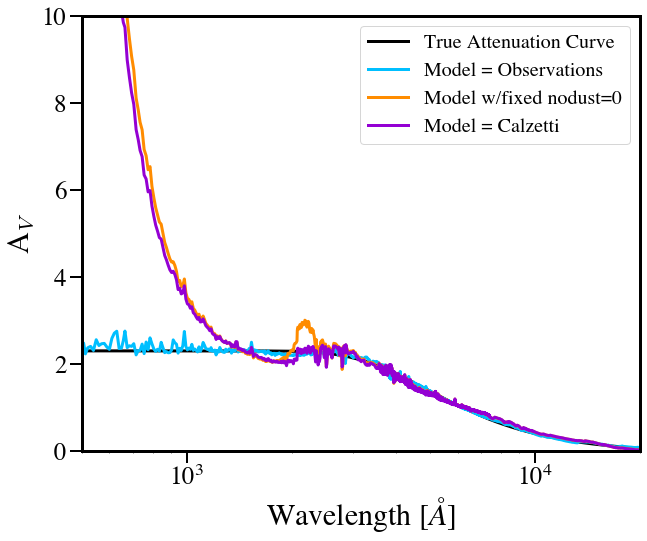

In [47]:
plt.plot(spec_waves, attn_true, color='black', lw=3, label='True Attenuation Curve')
plt.plot(spec_waves, attn_og, color='deepskyblue', lw=3, label='Model = Observations')

plt.plot(spec_waves, attn_kc, color='darkorange', lw=3, label='Model w/fixed nodust=0')
plt.plot(spec_waves, attn_cal, color='darkviolet', lw=3, label='Model = Calzetti')
plt.xscale('log')
plt.ylim([0, 10])
plt.xlim([5e2, 2e4])
plt.legend()
plt.ylabel('A$_V$')
plt.xlabel('Wavelength [$\AA$]')
plt.savefig(savedir+'eff_atten_curve.png', dpi=300, bbox_inches='tight')

In [56]:
res.keys()

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])

In [58]:
res['model']

In [59]:
rescal['model']

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=50000000.0,maxi=10000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-1.9,maxi=0.2)
  dust2: <class 'prospect.models.priors.ClippedNormal'>(mean=0.3,sigma=1,mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=14.0)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=10)
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=25)
  duste_gamma: <class 'prospect.models.priors.LogUniform'>(mini=0.001,maxi=0.15)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.1] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_dust_emission: [ True] 
  duste_qpah: [5.86] 
  lumdist: [1.e-05] 
  dust1: [0.] 
  dust_index: [-0.7] 
  frac_nodust: [0.] 
  uvb: [0.] 

In [60]:
rescal.keys()

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])

In [61]:
pread.get_sps(rescal)

In [67]:
simba_dat = np.load('/Users/sidneylower/Documents/atten_demos/galaxy_10.npz', allow_pickle=True)

In [68]:
list(simba_dat.keys())

['data']

In [72]:
res_sim, _, mod_sim = pread.results_from('/Users/sidneylower/Documents/atten_demos/galaxy_10.h5')

In [71]:
mass50 = simba_dat['data'][()]['Mass_50']
mass16 = simba_dat['data'][()]['Mass_16']
mass84 = simba_dat['data'][()]['Mass_84']
truemass = simba_dat['data'][()]['True Mass']

In [74]:
res_sim.keys()

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])

In [95]:
new_file = res_sim['paramfile_text'].replace('sys.argv[1]', '0')
new_file = new_file.replace('np.loadtxt(mz_dir)', '0')

In [96]:
import os
param_file = (rescal['run_params'].get('param_file', ''),
                  new_file)
path, filename = os.path.split(param_file[0])
modname = filename.replace('.py', '')
user_module = pread.import_module_from_string(param_file[1], modname)

In [98]:
mod_sim = user_module.build_model(**res['run_params'])

loading model


In [99]:
thetas = mod_sim.theta_labels()

In [100]:
thetas

['dust2',
 'z_fraction_1',
 'z_fraction_2',
 'z_fraction_3',
 'z_fraction_4',
 'z_fraction_5',
 'z_fraction_6',
 'z_fraction_7',
 'z_fraction_8',
 'z_fraction_9',
 'total_mass',
 'duste_umin',
 'duste_gamma',
 'dust_index',
 'frac_nodust',
 'uvb',
 'massmet_1',
 'massmet_2']

In [102]:
simba_mass_post = [item[thetas.index('massmet_1')] for item in res_sim['chain']]

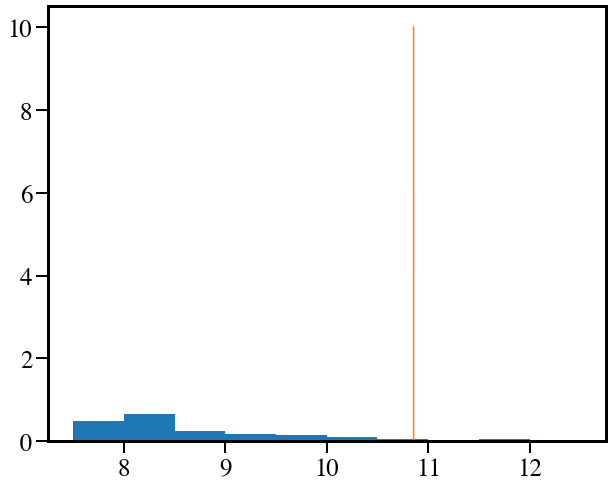

In [106]:
plt.hist(simba_mass_post, density=True)
plt.plot([np.log10(truemass/1.989e33), np.log10(truemass/1.9898e33)], [0, 10])

In [108]:
simba_nodust_post = [item[thetas.index('frac_nodust')] for item in res_sim['chain']]

(array([ 294.,  337.,  385.,  408.,  435.,  481.,  609., 1049., 1846.,
        1575.]),
 array([3.29963912e-05, 1.20291722e-02, 2.40253481e-02, 3.60215239e-02,
        4.80176997e-02, 6.00138756e-02, 7.20100514e-02, 8.40062273e-02,
        9.60024031e-02, 1.07998579e-01, 1.19994755e-01]),
 <a list of 10 Patch objects>)

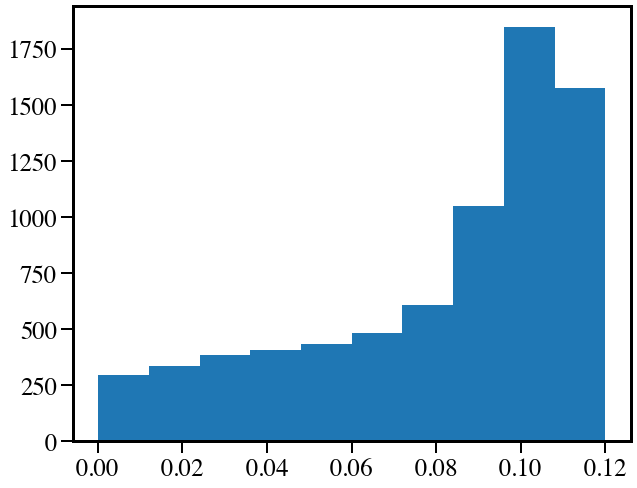

In [109]:
plt.hist(simba_nodust_post)

In [113]:
sps_sim = user_module.build_sps(**res['run_params'])

initiating sps


In [110]:
thetas_sim = get_best(res_sim)

In [120]:
spec_sim, _, _ = mod_sim.mean_model(thetas_sim, res['obs'], sps_sim)
sim_wav = sps_sim.wavelengths

In [116]:
from hyperion.model import ModelOutput
from astropy import units as u
from astropy import constants
m = ModelOutput("/Users/sidneylower/Documents/atten_demos/snap305.galaxy10.rtout.sed")
wav,flux = m.get_sed(inclination=0,aperture=-1)
wav  = np.asarray(wav)*u.micron #wav is in micron                                                                                                        
wav = wav.to(u.AA)
flux = np.asarray(flux)*u.erg/u.s
dl = (10. * u.pc).to(u.cm)
flux /= (4.*3.14*dl**2.)
nu = constants.c.cgs/(wav.to(u.cm))
nu = nu.to(u.Hz)
flux /= nu
flux = flux.to(u.Jy)
flux /= 3631

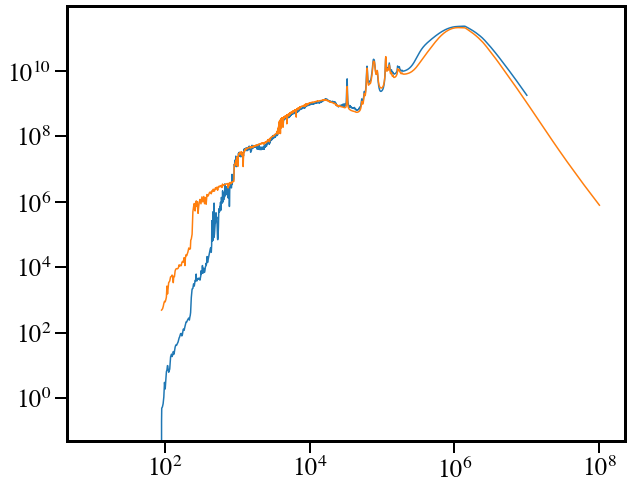

In [121]:
plt.loglog(wav, flux)
plt.loglog(sim_wav, spec_sim)

In [123]:
a = np.load('/Volumes/orange/narayanan/s.lower/simba/pyloser_los_extinction/pyloser_computeAV_galaxy10.npz')

In [126]:
import tqdm

In [156]:
frac_nodust_simba = []
Av_list = []
for i in tqdm.tqdm(range(2000)):
    try:
        dat = np.load('/Volumes/orange/narayanan/s.lower/simba/pyloser_los_extinction/pyloser_computeAV_galaxy'+str(i)+'.npz')
    except:
        continue 
    Av = dat['AV_per_star']
    Av_list.append([Av])
    nodust = np.where(np.log10(Av) < -8.)[0]
    total_stars = dat['stars']
    frac_nodust_simba.append(len(nodust) / total_stars)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 2000/2000 [03:35<00:00,  9.26it/s]


In [168]:
frac = []
for i in tqdm.tqdm(range(len(Av_list))):
    nodust = np.where(np.log10(Av_list[i]) < -8.5)[0]
    frac.append(len(nodust) / len(Av_list[i]))
    

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2000/2000 [00:00<00:00, 32813.76it/s]


In [190]:
def nodust_fit(x, amp, tau):
    return amp*np.exp(-x*tau)

In [187]:
x = np.linspace(0, 0.5, 100)

(0, 1200)

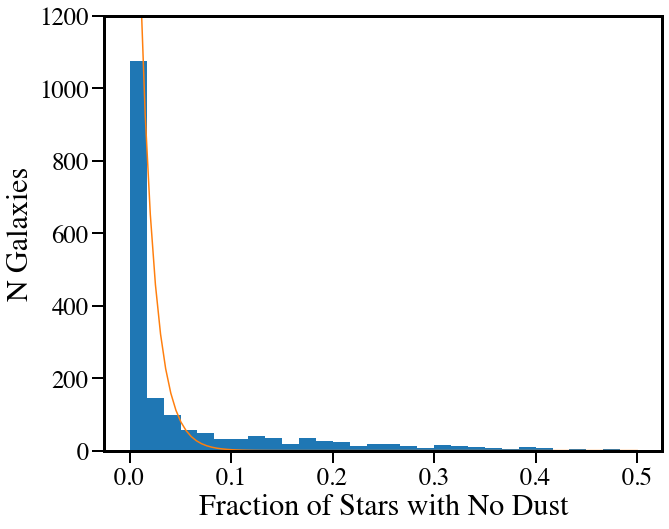

In [211]:
n, bins, _ = plt.hist(frac, bins=30, range=(0, 0.5))
plt.plot(x, nodust_fit(x, popt[0], 70))
plt.xlabel('Fraction of Stars with No Dust')
plt.ylabel('N Galaxies')
plt.ylim([0, 1200])
#plt.savefig('/Users/sidneylower/Documents/atten_demos/frac_nodust_simba_zoomout.png', dpi=300, bbox_inches='tight')

In [175]:
from scipy.optimize import curve_fit

In [202]:
midpoints = (bins[1:] + bins[:-1])/2

In [203]:
popt, pcov = curve_fit(nodust_fit, midpoints, n)

In [204]:
popt

array([2682.11763485,  110.0839214 ])

In [142]:
import yt

In [143]:
ds = yt.load('/Volumes/orange/narayanan/s.lower/simba/filtered_snapshots/snap305/galaxy_100.hdf5')

yt : [INFO     ] 2020-06-14 20:01:37,694 Calculating time from 1.000e+00 to be 4.375e+17 seconds
yt : [INFO     ] 2020-06-14 20:01:37,696 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2020-06-14 20:01:37,751 Parameters: current_time              = 4.3748565942961094e+17 s
yt : [INFO     ] 2020-06-14 20:01:37,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-06-14 20:01:37,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-06-14 20:01:37,755 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2020-06-14 20:01:37,757 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-06-14 20:01:37,758 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2020-06-14 20:01:37,759 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2020-06-14 20:01:37,761 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2020-06-14 20:01:37,761 Parameters: omega_radiation 

In [144]:
ad = ds.all_data()

yt : [INFO     ] 2020-06-14 20:01:55,075 Allocating for 2.204e+04 particles


In [146]:
ad[('PartType0', 'SmoothingLength')].in_units('kpc')

unyt_array([1.02941175, 1.16303063, 1.26131107, ..., 1.03014208,
            1.02941175, 1.03063084], 'kpc')

In [94]:
xdir = np.load('/Users/sidneylower/Documents/atten_demos/los_AV_caesar_per_galaxy_xdir.npz', allow_pickle=True)
ydir = np.load('/Users/sidneylower/Documents/atten_demos/los_AV_caesar_per_galaxy_ydir.npz', allow_pickle=True)
zdir = np.load('/Users/sidneylower/Documents/atten_demos/los_AV_caesar_per_galaxy_zdir.npz', allow_pickle=True)


avx = xdir['Av']
avy = ydir['Av']
avz = zdir['Av']

In [95]:
avs = []
for i in range(2000):
    stellar_av = np.array([avx[i], avy[i], avz[i]])
    gal_average = np.mean(stellar_av, axis=0)
    avs.append(gal_average)

/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


(0, 0.8)

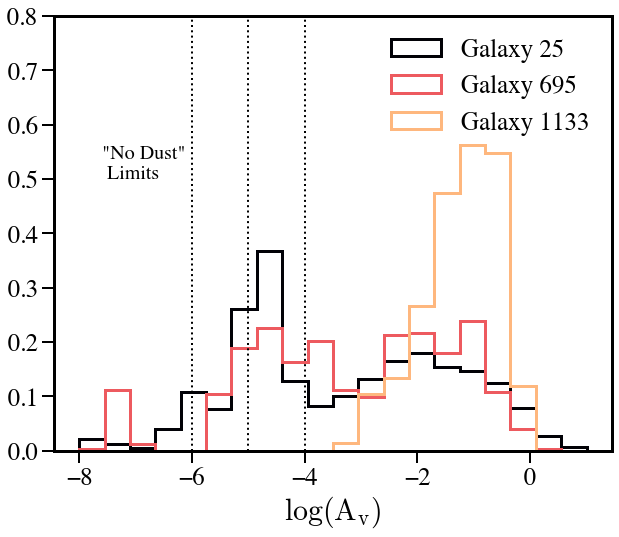

In [149]:
cmap = matplotlib.cm.get_cmap('magma')

i, v, j = 25, 695, 1133

plt.hist(np.log10(avs[i]), range=(-8, 1), bins=20, color=cmap(0.01), alpha=1, histtype='step', lw=3,label='Galaxy '+str(i), density=True)
plt.hist(np.log10(avs[v]), range=(-8, 1), bins=20, color=cmap(0.65), alpha=1,histtype='step',lw=3,label='Galaxy '+str(v), density=True)
plt.hist(np.log10(avs[j]), range=(-8, 1), bins=20, color=cmap(0.85),alpha=1, histtype='step',lw=3,label='Galaxy '+str(j), density=True)
plt.plot([-6, -6], [0, 1.0], color='black', lw=2.0, ls=':')
plt.plot([-5, -5], [0, 1.0], color='black', lw=2.0, ls=':')
plt.plot([-4, -4], [0, 1.0], color='black', lw=2.0, ls=':')
plt.legend(loc='upper right', frameon=False, fontsize=25)
plt.annotate('"No Dust"\n Limits', xy=(-7.6, 0.5), fontsize=20)
plt.xlabel('$\log(\mathrm{A_v})$')
plt.ylim([0, 0.8])
#plt.savefig('/Users/sidneylower/Documents/atten_demos/av_galaxy_dist.png', dpi=300, bbox_inches='tight')

In [140]:
frac_nodust_0 = []
frac_nodust_2 = []
frac_nodust_5 = []
frac_nodust_8 = []
for i in range(2000):
    av_per_star = avs[i]
    nodust2 = len(np.where(np.log10(av_per_star) < -4)[0])
    nodust5 = len(np.where(np.log10(av_per_star) < -5)[0])
    nodust8 = len(np.where(np.log10(av_per_star) < -6)[0])
    nodust0 = len(np.where(av_per_star == 0.0 )[0])
    frac_nodust_0.append(nodust0 / len(av_per_star))
    frac_nodust_2.append(nodust2 / len(av_per_star))
    frac_nodust_5.append(nodust5 / len(av_per_star))
    frac_nodust_8.append(nodust8 / len(av_per_star))

/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


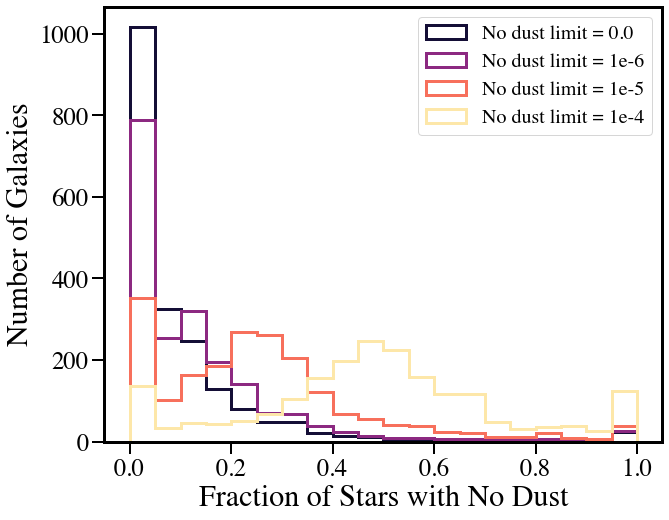

In [144]:
cmap = matplotlib.cm.get_cmap('magma')
plt.hist(frac_nodust_0, bins=20, color=cmap(0.1), histtype='step', lw=3, label='No dust limit = 0.0')
plt.hist(frac_nodust_8, bins=20, color=cmap(0.4),histtype='step', lw=3, label='No dust limit = 1e-6')
plt.hist(frac_nodust_5, bins=20, color=cmap(0.7),histtype='step', lw=3, label='No dust limit = 1e-5')
plt.hist(frac_nodust_2, bins=20, color=cmap(0.95),histtype='step', lw=3, label='No dust limit = 1e-4')
plt.legend()
plt.xlabel('Fraction of Stars with No Dust')
plt.ylabel('Number of Galaxies')
plt.savefig(savedir+'/nodust_stars_all_galaxies.png', dpi=300, bbox_inches='tight')

In [434]:
from scipy.stats import norm
from prospect.models import priors

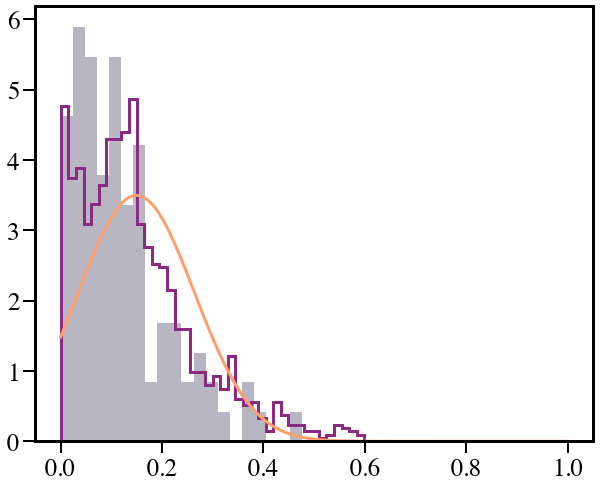

In [439]:
test = []
clip_norm = priors.ClippedNormal(mini=0, maxi=0.6, mean=0.01, sigma=0.15)
for i in range(100):
    test.append(clip_norm.sample()[0])
frac_nodust_8 = np.asarray(frac_nodust_8)
mask_frac = np.where((frac_nodust_8 > 0.0) & (frac_nodust_8 < 0.6))
plt.hist(frac_nodust_8[mask_frac], bins=40, color=cmap(0.4),histtype='step', lw=3, density=True, label='No dust limit = 1e-6')
plt.hist(test, bins=20, color=cmap(0.1),alpha=0.3, zorder=0,  density=True, label='Clipped Norm Fit')
mean, std = norm.fit(frac_nodust_8[mask_frac])
x = np.linspace(0, 1.0, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y, color=cmap(0.8), lw=3, label='Gaussian Fit')

In [437]:
test = []
clip_norm = priors.ClippedNormal(mini=0, maxi=0.6, mean=0.05, sigma=0.1)
for i in range(100):
    test.append(clip_norm.sample()[0])

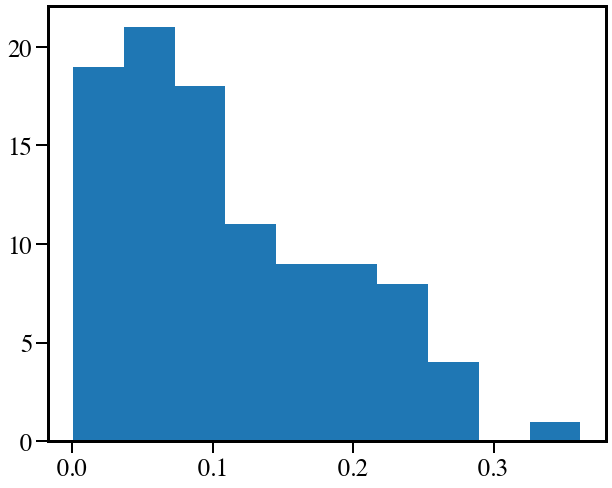

In [190]:
n, _, _ = plt.hist(test)

In [11]:
pd_data = pd.read_pickle('/Volumes/orange/narayanan/s.lower/simba/pd_runs/attenuation_curves/snap305/combined_data.pkl')

/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


Text(0, 0.5, 'A$_{\\lambda}$')

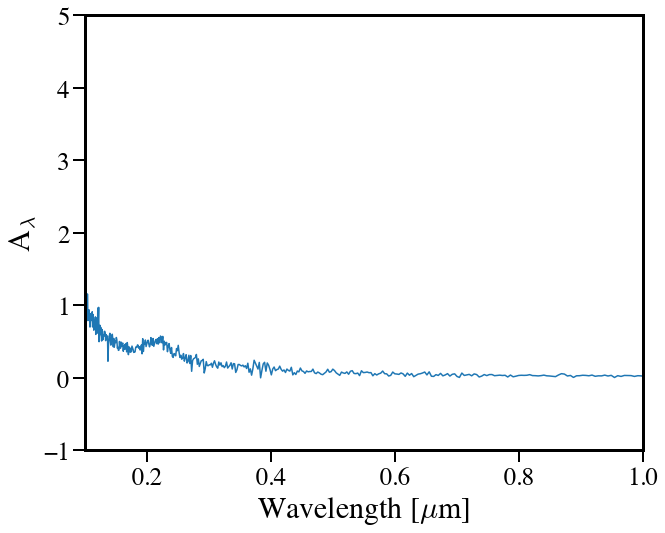

In [14]:
#for i in range(100):
#    mask = ~np.isnan(np.log10(pd_data['tau_list'][i][0]))
#    plt.plot(pd_data['wavelengths'][0][mask], pd_data['tau_list'][i][0][mask])

i = 70

mask = ~np.isnan(np.log10(pd_data['tau_list'][i][0]))
plt.plot(pd_data['wavelengths'][0][mask], pd_data['tau_list'][i][0][mask])


#plt.xscale('log')
plt.xlim([0.1, 1])
plt.ylim([-1, 5])
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('A$_{\lambda}$')

In [ ]:
IF (x.GT.12.) mwdindex(6)=j
IF (x.GE.8.)  mwdindex(5)=j
IF (x.GE.5.9) mwdindex(4)=j
IF (x.GE.3.3) mwdindex(3)=j
IF (x.GE.1.1) mwdindex(2)=j
IF (x.GE.0.1) mwdindex(1)=j

In [24]:
def Cardelli_fspsparam(lam, dust2, uvb, mwr):
    #mwr = 3.1
    x = 1e4 / lam
    y = x - 1.82
    a = np.empty(len(x))
    b = np.empty(len(x))
    attn_curve = np.empty(len(x))
    for i in range(len(x)):
        
        if 0.1 < x[i] <= 1.1: #IR
            a[i] = 0.574*x[i]**1.61
            b[i] = (-0.527*x[i]**1.61) / mwr
        
        elif 1.1 < x[i] <= 3.3: #optical - NIR   
            a[i] = 1 + 0.177*y[i] - 0.50477*y[i]**2 - 0.0243*y[i]**3 + 0.721*y[i]**4 + 0.0198*y[i]**5 - 0.7753*y[i]**6 + 0.33*y[i]**7
            b[i] = (1.4134*y[i] + 2.283*y[i]**2 + 1.072*y[i]**3 - 5.385*y[i]**4 - 0.6225*y[i]**5 + 5.303*y[i]**6 - 2.09*y[i]**7) / mwr
    
        elif 3.3 < x[i] <= 5.9: #near UV
            f_a = (3.3/x[i])**6.*(-0.037 + 0.0469*uvb - (0.601*uvb / mwr) + 0.542/mwr)
            a[i] = 1.752-0.316*x[i]-0.104/((x[i]-4.67)**2+0.341)*uvb + f_a
            b[i] = (-3.09+1.825*x[i]+1.206/((x[i]-4.62)**2+0.263)*uvb ) / mwr
        
        elif 5.9 < x[i] <= 8.: #mid-UV
            f_a = -0.04473*(x[i]-5.9)**2-0.009779*(x[i]-5.9)**3
            f_b =  0.2130*(x[i]-5.9)**2+0.1207*(x[i]-5.9)**3
            a[i]  = 1.752-0.316*x[i]-0.104/((x[i]-4.67)**2+0.341)*uvb + f_a
            b[i]  = (-3.09+1.825*x[i]+1.206/((x[i]-4.62)**2+0.263)*uvb + f_b) / mwr
            
        elif 8. < x[i] <= 12.0: #far UV
            a[i] = -1.073-0.628*(x[i]-8.)+0.137*(x[i]-8.)**2-0.070*(x[i]-8.)**3
            b[i] = (13.67+4.257*(x[i]-8.)-0.42*(x[i]-8.)**2+0.374*(x[i]-8.)**3) / mwr
        
        else: #far far UV?
            a[i] = -1.073 - 0.628*(12.-8.)+0.137*(12.-8.)**2-0.070*(12.-8.)**3
            b[i] = (13.67+4.257*(12.-8.)-0.42*(12.-8.)**2+0.374*(12.-8.)**3) / mwr

             
            
    
    
    for i in range(len(x)):
        attn_curve[i] = (a[i] + b[i])
        
    
    return attn_curve*dust2

In [7]:
from scipy.optimize import curve_fit
import numpy as np

In [91]:
i = 70
mask = np.where((pd_data['wavelengths'][0] >= 0.1) & (pd_data['wavelengths'][0] <= 1.0))[0]
x = pd_data['wavelengths'][0][mask]
y = pd_data['tau_list'][i][0][mask]

In [92]:
params, unc = curve_fit(Cardelli_fspsparam, np.array([z*1e4 for z in x]), y)

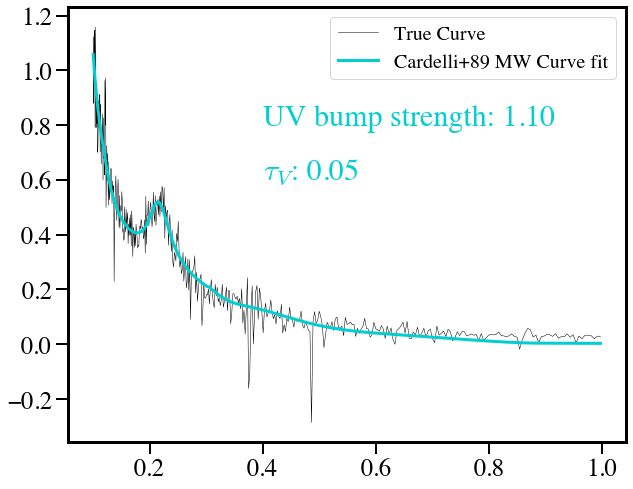

In [93]:
plt.plot(x, y, label='True Curve', color='black', lw=0.5)
plt.plot(x, Cardelli_fspsparam(np.array([z*1e4 for z in x]), *params), lw=3, label='Cardelli+89 MW Curve fit', color='darkturquoise')
plt.legend()
plt.annotate('UV bump strength: '+"{:.2f}".format(params[1]), xy=(0.4, 0.8), color='darkturquoise')
plt.annotate(r'$\tau_V$: '+"{:.2f}".format(params[0]), xy=(0.4, 0.6), color='darkturquoise')
plt.savefig('/Users/sidneylower/Documents/atten_demos/curve_fit_galaxy70.png', dpi=300, bbox_inches='tight')

In [31]:
uvb_rel_to_MW = []
mask = np.where((pd_data['wavelengths'][0] >= 0.1) & (pd_data['wavelengths'][0] <= 1.0))[0]
x = pd_data['wavelengths'][0][mask]
for i in tqdm.tqdm(range(len(pd_data['tau_list']))):
    y = pd_data['tau_list'][i][0][mask]
    params, unc = curve_fit(Cardelli_fspsparam, np.array([z*1e4 for z in x]), y)
    uvb_rel_to_MW.append(params[1])

100%|██████████| 1797/1797 [05:02<00:00,  5.93it/s]


In [55]:
from scipy.stats import norm

In [85]:
mask_uvb = np.where((np.asarray(uvb_rel_to_MW) > 0.0) & (np.asarray(uvb_rel_to_MW) < 4.0))[0]

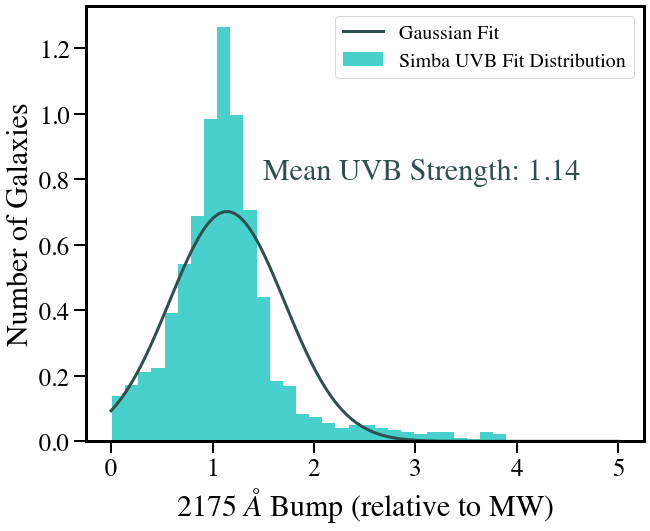

In [440]:
plt.hist(np.array(uvb_rel_to_MW)[mask_uvb] ,bins=30, density=True,color='mediumturquoise', label='Simba UVB Fit Distribution')
mean,std=norm.fit(np.array(uvb_rel_to_MW)[mask_uvb])
x = np.linspace(0, 5, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y, color='darkslategrey', lw=3, label='Gaussian Fit')
plt.xlabel('2175 $\AA$ Bump (relative to MW)')
plt.annotate('Mean UVB Strength: '+"{:.2f}".format(mean), xy=(1.5, 0.8), color='darkslategrey')
plt.ylabel('Number of Galaxies')
plt.legend()
plt.savefig('/Users/sidneylower/Documents/atten_demos/uvb_dist.png', dpi=300, bbox_inches='tight')

In [441]:
mean, std

(1.1420856703490727, 0.56825674803043)

In [2]:
import sys
def get_best(res, **kwargs):
    """Get the maximum a posteriori parameters.                                                                                                               
    From prospect.utils.plotting                                                                                                                              
    """
    imax = np.argmax(res['lnprobability'])
    # there must be a more elegant way to deal with differnt shapes                                                                                           
    theta_best = res['chain'][imax, :].copy()

    return theta_best

In [3]:
sys.path.append('/Volumes/orange/narayanan/s.lower/prospector/simba_runs/dust-priors_fixed-sfh/')
from run_prosp import build_model, build_sps

In [4]:
res, _, _ = pread.results_from('/Volumes/orange/narayanan/s.lower/prospector/simba_runs/dust-priors_fixed-sfh/galaxy_50_06172020.h5')

In [5]:
import yt

In [6]:
ds = yt.load('/Volumes/orange/narayanan/s.lower/simba/filtered_snapshots/snap305/galaxy_50.hdf5')

yt : [INFO     ] 2020-06-17 22:33:23,519 Calculating time from 1.000e+00 to be 4.375e+17 seconds
yt : [INFO     ] 2020-06-17 22:33:23,521 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2020-06-17 22:33:23,573 Parameters: current_time              = 4.3748565942961094e+17 s
yt : [INFO     ] 2020-06-17 22:33:23,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-06-17 22:33:23,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-06-17 22:33:23,576 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2020-06-17 22:33:23,577 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-06-17 22:33:23,579 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2020-06-17 22:33:23,580 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2020-06-17 22:33:23,581 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2020-06-17 22:33:23,583 Parameters: omega_radiation 

In [7]:
mod = build_model(galaxy=50, local=True)
sps = build_sps()

loading model
['mass', 'logzsol', 'dust2', 'duste_umin', 'duste_gamma', 'dust_index', 'frac_nodust', 'uvb']
initiating sps


In [8]:
thetas = mod.theta_labels()

In [9]:
theta_best = get_best(res)

In [36]:
np.log10(theta_best[0]*0.5)

11.88817523015598

In [10]:
ad = ds.all_data()

yt : [INFO     ] 2020-06-17 22:34:08,748 Allocating for 3.333e+04 particles


In [13]:
true_mass = np.sum(ad[('PartType4', 'Masses')].in_units('Msun').value)
solar = 0.0196
true_z = np.sum(ad[('PartType4', 'Masses')].value * ad[('PartType4', 'metallicity')].value) / np.sum(ad[('PartType4', 'Masses')].value)

In [12]:
z_post = [item[thetas.index('logzsol')] for item in res['chain']]

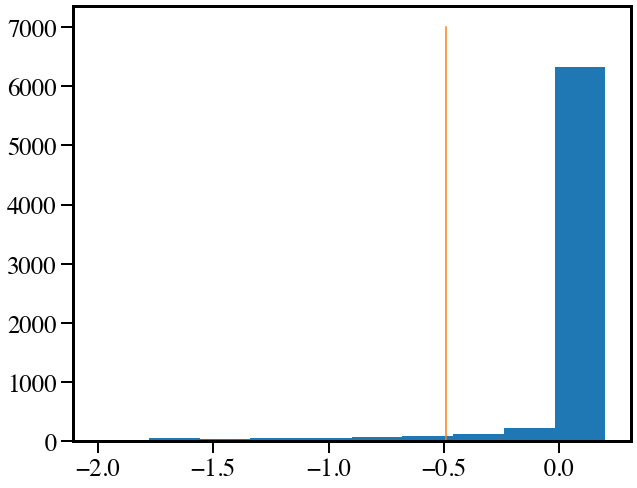

In [15]:
plt.hist(z_post)
plt.plot([np.log10(true_z/solar), np.log10(true_z/solar)], [0, 7000])

In [30]:
mass_post = [np.log10(item[thetas.index('mass')] * 0.2) for item in res['chain']]

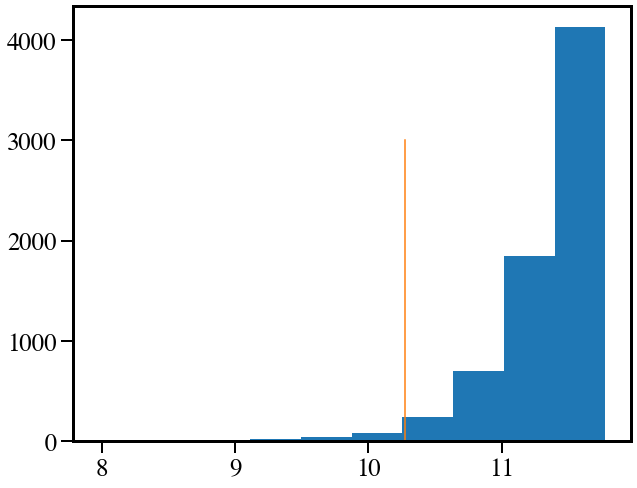

In [31]:
plt.hist(mass_post)
plt.plot([np.log10(true_mass), np.log10(true_mass)], [0, 3000])

In [32]:
frac_post = [item[thetas.index('frac_nodust')] for item in res['chain']]

(array([5.240e+02, 5.218e+03, 1.150e+03, 9.900e+01, 5.900e+01, 1.300e+01,
        1.100e+01, 2.000e+00, 0.000e+00, 3.000e+00]),
 array([2.09379439e-05, 4.91016191e-02, 9.81823002e-02, 1.47262981e-01,
        1.96343663e-01, 2.45424344e-01, 2.94505025e-01, 3.43585706e-01,
        3.92666387e-01, 4.41747068e-01, 4.90827749e-01]),
 <a list of 10 Patch objects>)

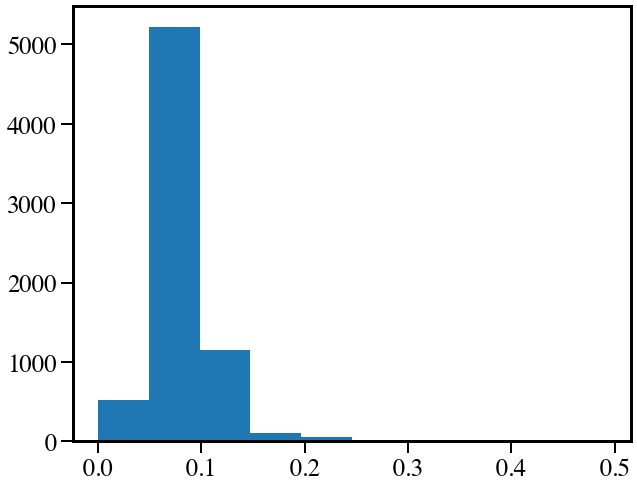

In [33]:
plt.hist(frac_post)